In [ ]:
!pip install pydicom
import pydicom as dicom

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
import cv2
import glob
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load train data
tf.disable_v2_behavior()
seed = 0
eps = 1e-8
rng = np.random.RandomState(seed)
tf.set_random_seed(seed)
np.seterr(all='raise')

data_path = '/content/drive/My Drive/AML_assn1/ProcessedData/'
Xs_sup = []
ys_sup = []

Xs_unsup = []
img_files = sorted(glob.glob(data_path + 'input/*.dcm'))
gti_files = sorted(glob.glob(data_path + 'gt_icontour/*.png'))
gto_files = sorted(glob.glob(data_path + 'gt_ocontour/*.png'))

unsup_files = sorted(glob.glob(data_path + 'no_gt_input/*.dcm'))
for dcm_file in img_files:
  ds = dicom.dcmread(dcm_file)
  img_data = np.array(ds.pixel_array)
  img_data = np.float32(img_data)/np.max(img_data)
  img_data = np.expand_dims(img_data, axis=-1)
  if img_data.shape[0]<img_data.shape[1]:
    img_data = np.transpose(img_data, axes=(1, 0, 2))
  Xs_sup.append(img_data)

for i in range(len(gti_files)):
  gti_file = gti_files[i]
  gto_file = gto_files[i]
  
  im_icontour = cv2.imread(gti_file, cv2.IMREAD_GRAYSCALE)
  im_ocontour = cv2.imread(gto_file, cv2.IMREAD_GRAYSCALE)

  im_icontour = np.float32(im_icontour)/np.max(im_icontour)
  im_ocontour = np.float32(im_ocontour)/np.max(im_ocontour)
  
  im_icontour = np.expand_dims(im_icontour, axis=-1)
  im_ocontour = np.expand_dims(im_ocontour, axis=-1)

  im_contour = np.concatenate((im_icontour, im_ocontour), axis=2)
  if im_contour.shape[0]<im_contour.shape[1]:
    im_contour = np.transpose(im_contour, axes=(1, 0, 2))
  ys_sup.append(im_contour)


In [ ]:
#load test data
data_path = '/content/drive/My Drive/AML_assn1/ProcessedTest1Data/'
Xs_test = []
ys_test = []

test_img_files = sorted(glob.glob(data_path + 'input/*.dcm'))
test_gti_files = sorted(glob.glob(data_path + 'gt_icontour/*.png'))
test_gto_files = sorted(glob.glob(data_path + 'gt_ocontour/*.png'))

for dcm_file in test_img_files:
  ds = dicom.dcmread(dcm_file)
  img_data = np.array(ds.pixel_array)
  img_data = np.float32(img_data)/np.max(img_data)
  img_data = np.expand_dims(img_data, axis=-1)
  if img_data.shape[0]<img_data.shape[1]:
    img_data = np.transpose(img_data, axes=(1, 0, 2))
  Xs_test.append(img_data)

for i in range(len(test_gti_files)):
  gti_file = test_gti_files[i]
  gto_file = test_gto_files[i]
  
  im_icontour = cv2.imread(gti_file, cv2.IMREAD_GRAYSCALE)
  im_ocontour = cv2.imread(gto_file, cv2.IMREAD_GRAYSCALE)

  im_icontour = np.float32(im_icontour)/np.max(im_icontour)
  im_ocontour = np.float32(im_ocontour)/np.max(im_ocontour)
  
  im_icontour = np.expand_dims(im_icontour, axis=-1)
  im_ocontour = np.expand_dims(im_ocontour, axis=-1)

  im_contour = np.concatenate((im_icontour, im_ocontour), axis=2)
  if im_contour.shape[0]<im_contour.shape[1]:
    im_contour = np.transpose(im_contour, axes=(1, 0, 2))
  ys_test.append(im_contour)

In [ ]:
#augment data with lr and ud flips (use np.fliplr() and np.flipud())
for i in range(len(Xs_sup)):
  in_im = Xs_sup[i]
  gt_im = ys_sup[i]
  in_flip1 = np.fliplr(in_im)
  gt_flip1 = np.fliplr(gt_im)

  in_flip2 = np.flipud(in_im)
  gt_flip2 = np.flipud(gt_im)

  in_flip3 = np.flipud(in_flip1)
  gt_flip3 = np.flipud(gt_flip1)

  Xs_sup.append(in_flip1)
  Xs_sup.append(in_flip2)
  Xs_sup.append(in_flip3)

  ys_sup.append(gt_flip1)
  ys_sup.append(gt_flip2)
  ys_sup.append(gt_flip3)

In [ ]:
  '''
  from sklearn.model_selection import train_test_split
  frac = 0.8
  Xs_sup,_, ys_sup,_ = train_test_split(Xs_sup, ys_sup, train_size=frac, random_state=1)
  e_ = 1 #int(1/frac)
  #20,40,60,80,100
  '''


In [ ]:
print(len(ys_sup))
print(len(Xs_sup))

e_ = 1
print(Xs_sup[16].shape)
print(ys_sup[16].shape)

777
777


1.SIMPLE MODEL (No regularization)

[uncomment to use - comment out rest 3]

In [ ]:
#define model: Simple (no regularization)
'''
X_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])
prob = tf.placeholder_with_default(1.0, shape=())

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')
conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')
conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')


upsamp1 = tf.image.resize_nearest_neighbor(pool3, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal')
'''

2.Dropout Added in layers 3 and 4

[uncomment to use - comment out rest 3]

In [ ]:
#define model: Dropout
'''
X_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])
prob = tf.placeholder_with_default(1.0, shape=())

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')
conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal')
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')
conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal')
conv3 = tf.nn.dropout(conv3, keep_prob=prob)
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')


upsamp1 = tf.image.resize_nearest_neighbor(pool3, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal')
conv4 = tf.nn.dropout(conv4, keep_prob=prob)

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal')

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal')
'''

3.Drop Out + L2 regularizer

[uncomment to use - comment out rest 3]

In [ ]:
#define model: Drop Out + L2
'''
lambda_l2 = 0.05
X_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])
prob = tf.placeholder_with_default(1.0, shape=())

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')
conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')
conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv3 = tf.nn.dropout(conv3, keep_prob=prob)
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')


upsamp1 = tf.image.resize_nearest_neighbor(pool3, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv4 = tf.nn.dropout(conv4, keep_prob=prob)

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
'''

"\nlambda_l2 = 0.05\n#define model: Drop Out + L2\nX_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])\ny_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])\n\nconv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\npool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')\nconv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\npool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')\nconv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\nconv3 = tf.nn.dropout(conv3, keep_prob=0.5)\npool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')\n\n\nupsamp1 = tf.image.resize_nearest_neigh

4.Dropout + L2 regularizer + Batch Normalization

[uncomment to use - comment out rest 3]

In [ ]:
#define model: Dropout + L2 + BatchNorm
lambda_l2 = 0.05

X_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])
y_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])
prob = tf.placeholder_with_default(1.0, shape=())

conv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv1 = tf.layers.batch_normalization(conv1)
pool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')

conv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv2 = tf.layers.batch_normalization(conv2)
pool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')

conv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv3 = tf.layers.batch_normalization(conv3)
conv3 = tf.nn.dropout(conv3, keep_prob=prob)
pool3 = tf.nn.max_pool(conv3, 2, 2, 'SAME', name='pool3')


upsamp1 = tf.image.resize_nearest_neighbor(pool3, [conv3.shape[1], conv3.shape[2]], True, name='upsamp1')
concat1 = tf.concat([upsamp1, conv3], axis=3, name='concat1')
conv4 = tf.layers.conv2d(concat1, 32, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv4 = tf.layers.batch_normalization(conv4)
conv4 = tf.nn.dropout(conv4, keep_prob=prob)

upsamp2 = tf.image.resize_nearest_neighbor(conv4, [conv2.shape[1], conv2.shape[2]], True, name='upsamp2')
concat2 = tf.concat([upsamp2, conv2], axis=3, name='concat2')
conv5 = tf.layers.conv2d(concat2, 16, 3, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))
conv5 = tf.layers.batch_normalization(conv5)

upsamp3 = tf.image.resize_nearest_neighbor(conv5, [conv1.shape[1], conv1.shape[2]], True, name='upsamp3')
concat3 = tf.concat([upsamp3, conv1], axis=3, name='concat3')
out = tf.layers.conv2d(concat3, 2, 3, padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))


"\nlambda_l2 = 0.05\n#define model: Dropout + L2 + BatchNorm\nX_in = tf.placeholder('float', [1, Xs_sup[0].shape[0], Xs_sup[0].shape[1], Xs_sup[0].shape[2]])\ny_gt = tf.placeholder('float', [1, ys_sup[0].shape[0], ys_sup[0].shape[1], ys_sup[0].shape[2]])\n\nconv1 = tf.layers.conv2d(X_in, 16, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\nconv1 = tf.layers.batch_normalization(conv1)\npool1 = tf.nn.max_pool(conv1, 2, 2, 'SAME', name='pool1')\n\nconv2 = tf.layers.conv2d(pool1, 32, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\nconv2 = tf.layers.batch_normalization(conv2)\npool2 = tf.nn.max_pool(conv2, 2, 2, 'SAME', name='pool2')\n\nconv3 = tf.layers.conv2d(pool2, 64, 5, padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(lambda_l2))\nconv3 = tf.layers.batch_normalization(co

Define the loss function

In [ ]:
lambda_ce = 1
lambda_dice = 1
lambda_inv_dice = 1
lambda_reg = 0

In [ ]:
inv_out = 1-out
inv_gt = 1-y_gt
L_ce = tf.reduce_mean(-y_gt*tf.log(out+eps) - inv_gt*tf.log(inv_out+eps))
L_dice = 1 - (tf.reduce_sum(2*out*y_gt) + eps)/(tf.reduce_sum(out + y_gt) + eps)
L_inv_dice = 1 - (tf.reduce_sum(2*inv_out*inv_gt) + eps)/(tf.reduce_sum(inv_out + inv_gt) + eps)
L_reg = tf.reduce_mean(tf.nn.relu(out[:,:,:,0]-out[:,:,:,1]))

#L2 = tf.nn.l2_loss()

loss = lambda_ce*L_ce + lambda_dice*L_dice + lambda_inv_dice*L_inv_dice + lambda_reg*L_reg

optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

Run training code

In [ ]:
def compute_iou(out_contour_im, gt_contour_im):
  #both inputs are binary segmentations
  intersection = np.sum(gt_contour_im*out_contour_im)
  union = np.sum(np.clip(gt_contour_im + out_contour_im, 0, 1))
  return intersection/union

In [ ]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
epochs = int(21*e_)
loss_values = []
train_iou_values = []

test_loss_values = []
test_iou_values = []

batch_size = 1
data_size = len(Xs_sup)
test_size = len(Xs_test)

Xs_sup_array = np.array(Xs_sup)
ys_sup_array = np.array(ys_sup)

Xs_test_array = np.array(Xs_test)
ys_test_array = np.array(ys_test)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
  sess.run(tf.global_variables_initializer())
  for e in range(epochs):
    epoch_losses = []
    epoch_ious = []
    rand_perm = rng.permutation(len(Xs_sup))
    Xs_sup_array = Xs_sup_array[rand_perm]
    ys_sup_array = ys_sup_array[rand_perm]
    num_batches = data_size//batch_size
    for b in range(num_batches):
      in_batch = Xs_sup_array[b*batch_size:(b+1)*batch_size]
      gt_batch = ys_sup_array[b*batch_size:(b+1)*batch_size]
      #print(in_batch.shape)
      #print(gt_batch.shape)
      #print(in_batch.dtype)
      #print(gt_batch.dtype)
      feeds = {X_in: in_batch, y_gt: gt_batch, prob: 0.55}
      out_im, loss_val, _ = sess.run([out, loss, train_op], feed_dict=feeds)
      out_contour_im = np.copy(out_im)
      out_contour_im[out_contour_im>=0.5] = 1
      out_contour_im[out_contour_im<0.5] = 0
      batch_iou = compute_iou(out_contour_im, gt_batch)
      epoch_ious.append(batch_iou)
      epoch_losses.append(loss_val)
    if e%5 == 0:
      test_epoch_losses = []
      test_epoch_ious = []
      for tno in range(test_size):
        #test_in_batch = Xs_sup_array[tno:tno+1]
        #test_gt_batch = ys_sup_array[tno:tno+1]

        test_in_batch = Xs_test_array[tno:tno+1]
        test_gt_batch = ys_test_array[tno:tno+1]

        feeds = {X_in: test_in_batch, y_gt: test_gt_batch}
        test_out_im, test_loss_val = sess.run([out, loss], feed_dict=feeds)
        test_out_contour_im = np.copy(test_out_im)
        test_out_contour_im[test_out_contour_im>=0.5] = 1
        test_out_contour_im[test_out_contour_im<0.5] = 0
        test_batch_iou = compute_iou(test_out_contour_im, test_gt_batch)
        test_epoch_ious.append(test_batch_iou)
        test_epoch_losses.append(test_loss_val)
      test_epoch_mean_loss = np.mean(np.array(test_epoch_losses))
      test_epoch_mean_iou  = np.mean(np.array(test_epoch_ious))
      print('Test')
      print("epoch loss : " + str(test_epoch_mean_loss))
      print("epoch iou : " + str(test_epoch_mean_iou))
      test_loss_values.append(test_epoch_mean_loss)
      test_iou_values.append(test_epoch_mean_iou)

    epoch_mean_loss = np.mean(np.array(epoch_losses))
    epoch_mean_iou  = np.mean(np.array(epoch_ious))
    print('epoch : ' + str(e))
    print("epoch loss : " + str(epoch_mean_loss))
    print("epoch iou : " + str(epoch_mean_iou))
    loss_values.append(epoch_mean_loss)
    train_iou_values.append(epoch_mean_iou)

Test
epoch loss : 0.8885358
epoch iou : 0.23954959
epoch : 0
epoch loss : 1.0063915
epoch iou : 0.13293464
epoch : 1
epoch loss : 0.9122173
epoch iou : 0.22742525
epoch : 2
epoch loss : 0.8477223
epoch iou : 0.26984885
epoch : 3
epoch loss : 0.7861679
epoch iou : 0.30861866
epoch : 4
epoch loss : 0.7321854
epoch iou : 0.3474547
Test
epoch loss : 0.78186727
epoch iou : 0.29621458
epoch : 5
epoch loss : 0.6896957
epoch iou : 0.37811688
epoch : 6
epoch loss : 0.6487623
epoch iou : 0.40541396
epoch : 7
epoch loss : 0.6091789
epoch iou : 0.43477315
epoch : 8
epoch loss : 0.5831218
epoch iou : 0.45334643
epoch : 9
epoch loss : 0.55324656
epoch iou : 0.4756923
Test
epoch loss : 0.66733265
epoch iou : 0.39569858
epoch : 10
epoch loss : 0.52983326
epoch iou : 0.4928526
epoch : 11
epoch loss : 0.5104654
epoch iou : 0.50799614
epoch : 12
epoch loss : 0.49046296
epoch iou : 0.5230094
epoch : 13
epoch loss : 0.47625402
epoch iou : 0.534565
epoch : 14
epoch loss : 0.46916962
epoch iou : 0.5393967
Te

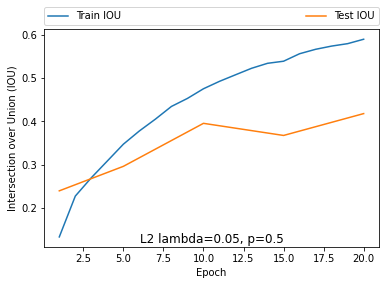

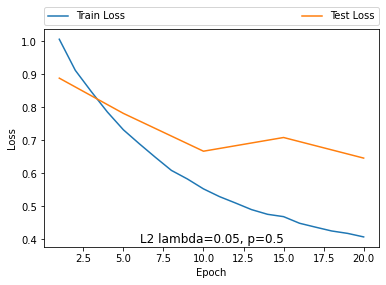

In [ ]:
#from matplotlib.ticker import MaxNLocator
#e_ = 5
plt.figure()

x_p = [x for x in range(1,21)]

#plt.plot(test_epoch_ious, label="Test IOU")
plt.plot(x_p, train_iou_values[:-1], label="Train IOU")
plt.plot([1,5,10,15,20], test_iou_values, label="Test IOU")

plt.ylabel('Intersection over Union (IOU)')
plt.xlabel('Epoch')
plt.title('L2 lambda=0.05, p=0.5', y=-0.01)

# Place a legend to the right of this smaller subplot.
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)



plt.figure()

#plt.plot(test_epoch_ious, label="Test IOU")
plt.plot([x for x in range(1,21)], loss_values[:-1], label="Train Loss")
plt.plot([1,5,10,15,20], test_loss_values, label="Test Loss")

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('L2 lambda=0.05, p=0.5', y=-0.01)

# Place a legend to the right of this smaller subplot.
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

plt.show()

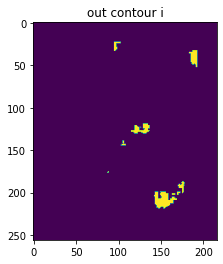

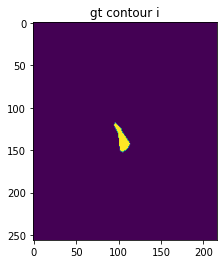

In [ ]:
plt.figure()
plt.title('out contour i')
plt.imshow(test_out_contour_im[0,:,:,0])

plt.figure()
plt.title('gt contour i')
plt.imshow(test_gt_batch[0,:,:,0])